### Importing Libraries

This cell imports all the necessary Python libraries for data manipulation, machine learning, and visualization. Each library serves a specific purpose:

*   **`pandas` (pd):** For data loading, manipulation, and analysis, especially with DataFrames.
*   **`numpy` (np):** For numerical operations, especially with arrays.
*   **`sklearn.model_selection`:** Provides tools like `train_test_split` for splitting data and `GridSearchCV`, `StratifiedKFold` for model tuning.
*   **`sklearn.ensemble`:** Contains ensemble learning methods like `RandomForestClassifier` and `GradientBoostingClassifier` (though `XGBoost` is used here, these might have been considered).
*   **`sklearn.metrics`:** For evaluating model performance, including `classification_report`, `accuracy_score`, and `confusion_matrix`.
*   **`shap`:** (SHapley Additive exPlanations) A library for explaining the output of machine learning models.
*   **`matplotlib.pyplot` (plt):** For creating static, interactive, and animated visualizations in Python.
*   **`xgboost` (xgb):** An optimized distributed gradient boosting library designed to be highly efficient, flexible, and portable.
*   **`joblib`:** For saving and loading Python objects, especially machine learning models.
*   **`IPython.display`:** Provides tools for displaying rich content in Jupyter notebooks, like `Image`.
*   **`imblearn.over_sampling`:** Contains methods like `SMOTE` for handling imbalanced datasets by over-sampling the minority class.
*   **`imblearn.pipeline`:** An extension of `scikit-learn`'s `Pipeline` to incorporate `imbalanced-learn` estimators.


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from IPython.display import Image, display
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

### Loading the Dataset

This cell loads the T20 ball-by-ball cricket dataset from a specified URL into a pandas DataFrame named `df`. It includes error handling for `FileNotFoundError` or any other general exceptions that might occur during the data loading process. Finally, it displays the first few rows of the loaded DataFrame to give a quick overview of its structure and content.

### Filtering Data for Sri Lanka Matches

This cell filters the main DataFrame `df` to include only those rows where the `Batting_Team` is 'Sri Lanka'. This creates a new DataFrame `df_sl`, focusing the analysis specifically on Sri Lanka's batting performance. The `.copy()` method is used to ensure that `df_sl` is an independent DataFrame, preventing `SettingWithCopyWarning` when modifications are made later.

In [17]:
file_path = 'https://raw.githubusercontent.com/ShiwanthaH/MiddleOverStrikeRateOptimizer/refs/heads/main/Dataset/Final/T20_ball_by_ball.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully!


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Extras_Type,Total_Runs_This_Ball,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR
0,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,0,No,NaN,NaN,0,0.0,Pace Friendly,88.89
1,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,0,No,NaN,NaN,0,0.0,Pace Friendly,88.89
2,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,1,1,No,NaN,NaN,0,2.0,Pace Friendly,88.89
3,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,2,3,No,NaN,NaN,0,4.5,Pace Friendly,0.00
4,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,3,No,NaN,NaN,0,3.6,Pace Friendly,0.00


In [18]:
df_sl = df[(df['Batting_Team'] == 'Sri Lanka')].copy()

### Preprocessing Bowler Information

This cell performs two main preprocessing steps:

1.  **Handling Missing Values:** It removes rows where either `Bowler_Type` or `Batter` columns have missing values (`dropna`), as these are crucial for subsequent analysis.
2.  **Grouping Bowler Types:** It defines a `group_bowler` function that categorizes different `Bowler_Type` values into broader groups such as 'Pace', 'Off-Spin', 'Leg-Spin', and 'Left-Arm Orthodox'. This simplifies the `Bowler_Type` feature and creates a new `Bowler_Group` column. This grouping helps in analyzing batter performance against general bowler categories rather than highly specific types, which can be beneficial for generalization in modeling.

Finally, it prints the shape of the DataFrame after these operations and displays the first few rows, including the newly created `Bowler_Group` column.

In [19]:
df_sl = df_sl.dropna(subset=['Bowler_Type', 'Batter'])

def group_bowler(bt):
    bt = str(bt).lower()
    if 'fast' in bt or 'medium' in bt: return 'Pace'
    if 'offbreak' in bt: return 'Off-Spin'
    if 'legbreak' in bt or 'wrist' in bt: return 'Leg-Spin'
    if 'orthodox' in bt: return 'Left-Arm Orthodox'
    return 'Other'
df_sl['Bowler_Group'] = df_sl['Bowler_Type'].apply(group_bowler)

print(df_sl.shape)
display(df_sl.head())

(25481, 30)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Total_Runs_This_Ball,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group
125,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,1,1,No,NaN,NaN,0,6.0,Pace Friendly,153.33,Pace
126,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,1,2,No,NaN,NaN,0,6.0,Pace Friendly,128.00,Pace
127,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,0,2,No,NaN,NaN,0,4.0,Pace Friendly,153.33,Pace
128,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,0,2,No,NaN,NaN,0,3.0,Pace Friendly,153.33,Pace
129,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,3,5,No,NaN,NaN,0,6.0,Pace Friendly,153.33,Pace


### Feature Engineering: Batter vs. Bowler Type Strike Rate

This crucial cell engineers a new feature: 'Batter vs. Bowler Type Strike Rate' (`Batter_vs_BowlerType_SR`). This feature is designed to capture how well a specific batter performs against a particular bowler group. Here's a breakdown of the steps:

1.  **Filter Legal Balls:** It first filters out 'wide' deliveries from `df_sl` because wide balls do not count towards a batter's balls faced and are usually not included in strike rate calculations.
2.  **Calculate Matchup Statistics:** It then groups the `df_legal_balls` by `Batter` and `Bowler_Group` to calculate the `Total_Runs` scored and `Total_Balls` faced for each unique batter-bowler group combination.
3.  **Calculate Strike Rate:** The `Batter_vs_BowlerType_SR` is computed as `(Total_Runs / Total_Balls) * 100`.
4.  **Handle Missing/Zero Values:** `fillna(0)` is used to handle potential division-by-zero errors (e.g., if a batter faced 0 balls against a bowler type in the legal balls dataset, though this is rare) and `round(2)` formats the strike rate.
5.  **Merge Feature:** The newly calculated `Batter_vs_BowlerType_SR` is merged back into the main `df_sl` DataFrame.
6.  **Fill Remaining NaNs:** Any remaining `NaN` values in `Batter_vs_BowlerType_SR` (which could occur if a batter never faced a particular bowler type in legal deliveries) are filled with a baseline T20 strike rate of `100.0`. This prevents issues with models like XGBoost that cannot handle `NaN` values and provides a reasonable default for unseen combinations.

This feature provides valuable contextual information about a batter's historical performance against different bowling styles, which is critical for tactical decision-making.

In [20]:
# ==========================================
# FEATURE ENGINEERING: Batter vs Bowler Type SR
# ==========================================

# 3. Filter out wide balls (wides do not count as a ball faced for a batter's strike rate)
# We assume 'Extras_Type' is 'N/A' for normal balls, and contains 'wides' for wide deliveries.
df_legal_balls = df_sl[~df_sl['Extras_Type'].str.contains('wides', case=False, na=False)]

# 4. Calculate total runs and total balls faced for every Batter-BowlerGroup combination
matchup_stats = df_legal_balls.groupby(['Batter', 'Bowler_Group']).agg(
    Total_Runs=('Batter_Runs', 'sum'),
    Total_Balls=('Batter_Runs', 'count')
).reset_index()

# 5. Calculate the Strike Rate: (Runs / Balls) * 100
matchup_stats['Batter_vs_BowlerType_SR'] = (matchup_stats['Total_Runs'] / matchup_stats['Total_Balls']) * 100

# Round to 2 decimal places and handle any rare division-by-zero errors
matchup_stats['Batter_vs_BowlerType_SR'] = matchup_stats['Batter_vs_BowlerType_SR'].fillna(0).round(2)

# 6. Merge the engineered feature back into the main dataframe
df_sl = df_sl.merge(
    matchup_stats[['Batter', 'Bowler_Group', 'Batter_vs_BowlerType_SR']],
    on=['Batter', 'Bowler_Group'],
    how='left'
)

# 7. Fill missing values (e.g., if a batter faces a bowler type for the very first time on a wide ball)
# We fill it with a baseline T20 strike rate of 100.0 to prevent NaN errors in XGBoost
df_sl['Batter_vs_BowlerType_SR'] = df_sl['Batter_vs_BowlerType_SR'].fillna(100.0)

# Verify the new column
print("--- New Feature Engineered Successfully ---")
print(df_sl[['Batter', 'Bowler_Group', 'Batter_vs_BowlerType_SR']].drop_duplicates().head(10))

# ==========================================
# Now you can proceed with filtering for Sri Lanka,
# dropping NaNs, and splitting your data!
# ==========================================

--- New Feature Engineered Successfully ---
             Batter Bowler_Group  Batter_vs_BowlerType_SR
0       N Dickwella         Pace                   127.57
1       WU Tharanga         Pace                   119.29
14   EMDY Munaweera         Pace                   134.62
39   EMDY Munaweera     Leg-Spin                   137.93
40      N Dickwella     Leg-Spin                   137.21
45   EMDY Munaweera     Off-Spin                    56.25
47      N Dickwella     Off-Spin                    95.45
56    DAS Gunaratne     Leg-Spin                    86.67
57    DAS Gunaratne         Pace                   140.32
68  TAM Siriwardana     Leg-Spin                   111.54


### Filtering for Middle Overs

This cell filters the `df_sl` DataFrame to include only the 'middle overs' of a T20 innings, defined as overs 7 through 15 (inclusive). The `between(7, 15)` method is used for this purpose. The middle overs are a critical phase in T20 cricket, characterized by a balance between scoring runs and preserving wickets. Analyzing this specific phase helps in understanding tactical decisions within a particular game context.

The cell then prints the shape of the filtered DataFrame and displays its head, confirming the applied filter.

In [21]:
df_sl = df_sl[(df_sl['Over'].between(7, 15))]

print(df_sl.shape)
display(df_sl.head())

(11653, 31)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR
45,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,69,No,NaN,NaN,1,9.63,Pace Friendly,92.86,Off-Spin,56.25
46,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.55,Pace Friendly,92.86,Off-Spin,56.25
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,71,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45
49,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,72,No,NaN,NaN,1,9.19,Pace Friendly,92.86,Off-Spin,56.25


### Filtering for Established Batters

This cell further refines the dataset by focusing only on 'established batters'. It calculates the number of balls faced by each batter using `value_counts()` on the 'Batter' column. Batters who have faced `100` or more balls are considered 'established' and are retained in the `df_sl` DataFrame. This step helps in ensuring that the analysis is based on batters with a sufficient sample size, leading to more reliable performance metrics and model predictions by reducing noise from players with very few appearances.

In [22]:
batter_counts = df_sl['Batter'].value_counts()
established_batters = batter_counts[batter_counts >= 100].index
df_sl = df_sl[df_sl['Batter'].isin(established_batters)]

print(df_sl.shape)
display(df_sl.head())

(10307, 31)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,71,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45
50,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,73,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Off-Spin,95.45
51,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,74,No,NaN,NaN,1,9.06,Pace Friendly,153.33,Leg-Spin,137.21
54,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,79,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Leg-Spin,137.21


### Defining Ball Outcome Categories

This cell introduces a crucial target variable for the model: `Ball_Outcome`. It defines a function `get_outcome` that categorizes each ball played into one of three tactical outcomes:

*   **0: Pressure (Dot/Wicket):** If a wicket falls (`Wicket == 'Yes'`) or no runs are scored (`Batter_Runs == 0`), indicating pressure on the batting side.
*   **1: Strike Rotation (1s, 2s, 3s):** If 1, 2, or 3 runs are scored, representing effective strike rotation and maintaining scoreboard pressure.
*   **2: Boundary (4s, 6s):** If 4 or 6 runs are scored, indicating aggressive scoring and boundary hitting.

This function is applied row-wise to the `df_sl` DataFrame to create the new `Ball_Outcome` column. This categorization simplifies the complex output of a cricket ball into meaningful tactical groups for machine learning, enabling the model to predict the likelihood of each type of event.

In [23]:
def get_outcome(row):
    if row['Wicket'] == 'Yes' or row['Batter_Runs'] == 0:
        return 0 # Pressure (Dot/Wicket)
    elif row['Batter_Runs'] in [1, 2, 3]:
        return 1 # Strike Rotation
    else:
        return 2 # Boundary
df_sl['Ball_Outcome'] = df_sl.apply(get_outcome, axis=1)

print(df_sl.shape)
display(df_sl.head())

(10307, 32)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR,Ball_Outcome
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45,0
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45,1
50,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Off-Spin,95.45,1
51,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.06,Pace Friendly,153.33,Leg-Spin,137.21,1
54,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Leg-Spin,137.21,2


### Analyzing Ball Outcome Distribution

This cell calculates and displays the distribution of the newly created `Ball_Outcome` categories (`Pressure`, `Strike Rotation`, `Boundary`) within the middle overs dataset. This is a critical step for understanding the target variable's composition and checking for class imbalance.

*   **`outcome_counts`:** Calculates the raw count of balls for each outcome.
*   **`outcome_percentages`:** Calculates the percentage of balls for each outcome by normalizing the counts.

The output shows:
*   **Class 0 - Pressure (Dot/Wicket): 35.88%** (3698 balls): This indicates that more than a third of the balls in the middle overs result in either a dot ball or a wicket, putting pressure on the batting team.
*   **Class 1 - Strike Rotation (1s, 2s, 3s): 52.28%** (5388 balls): This is the most frequent outcome, suggesting that batters prioritize rotating the strike during the middle overs.
*   **Class 2 - Boundary (4s, 6s): 11.85%** (1221 balls): Boundaries are the least frequent outcome, which is expected in the middle overs compared to powerplay or death overs.

This distribution highlights a class imbalance, where 'Strike Rotation' is the majority class, and 'Boundary' is a significant minority. This imbalance will be addressed later in the model training using custom weights to ensure the model doesn't over-predict the majority class.

--- Ball Outcome Distribution (Middle Overs) ---
Class 0 - Pressure (Dot/Wicket): 35.88% (3698 balls)
Class 1 - Strike Rotation (1s, 2s, 3s): 52.28% (5388 balls)
Class 2 - Boundary (4s, 6s): 11.85% (1221 balls)


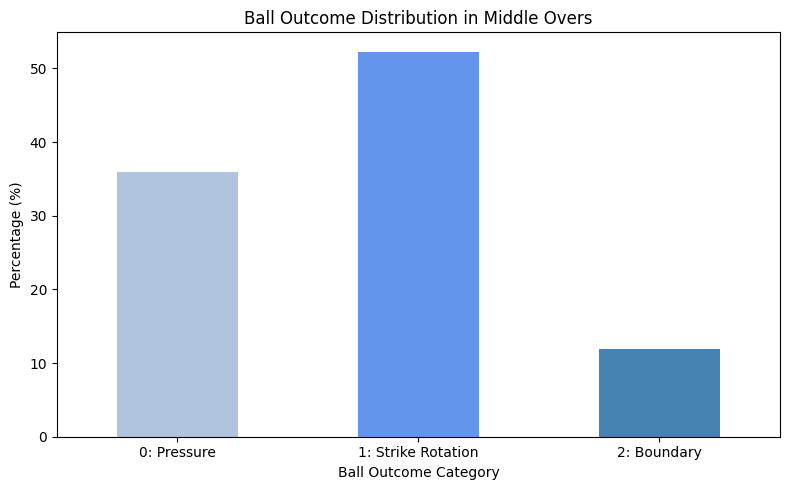

In [68]:
# 1. Calculate the total counts for each class
outcome_counts = df_sl['Ball_Outcome'].value_counts()

# 2. Calculate the percentage for each class (normalize=True gives the proportion)
outcome_percentages = df_sl['Ball_Outcome'].value_counts(normalize=True) * 100

# 3. Print the results clearly
print("--- Ball Outcome Distribution (Middle Overs) ---")
for cls in sorted(outcome_counts.index):
    if cls == 0:
        label = "Pressure (Dot/Wicket)"
    elif cls == 1:
        label = "Strike Rotation (1s, 2s, 3s)"
    else:
        label = "Boundary (4s, 6s)"

    print(f"Class {cls} - {label}: {outcome_percentages[cls]:.2f}% ({outcome_counts[cls]} balls)")

# 4. Visualize the differences with a bar plot
plt.figure(figsize=(8, 5))
outcome_percentages.sort_index().plot(kind='bar', color=['lightsteelblue', 'cornflowerblue', 'steelblue'])
plt.title('Ball Outcome Distribution in Middle Overs')
plt.xlabel('Ball Outcome Category')
plt.ylabel('Percentage (%)')
plt.xticks(ticks=[0, 1, 2], labels=['0: Pressure', '1: Strike Rotation', '2: Boundary'], rotation=0)
plt.tight_layout()
plt.show()

### Feature and Target Selection

This cell defines the features (`X`) and the target variable (`y`) for the machine learning model.

*   **`features`:** A list containing the names of the columns that will be used as input for the model. These include batter's name, bowler type, current over, cumulative wickets, current run rate, inning number, venue type, batter's last 5 strike rate, and batter vs. bowler type strike rate.
*   **`X`:** A DataFrame containing only the selected features from `df_sl`.
*   **`y`:** A Series containing the `Ball_Outcome` which the model will try to predict.

This separation of features and target is a standard practice in machine learning workflows, preparing the data for model training. The shape of `X` and `y` are printed to confirm their dimensions, and the head of `X` is displayed to show the selected features.

In [24]:
features = ['Batter', 'Bowler_Group', 'Over', 'Cumulative_Wickets','Current_Run_Rate', 'Inning', 'Venue_Type', 'Batter_Last5_SR', 'Batter_vs_BowlerType_SR']
X = df_sl[features]
y = df_sl['Ball_Outcome']

print(X.shape, y.shape)
display(X.head())

(10307, 9) (10307,)


,Batter,Bowler_Group,Over,Cumulative_Wickets,Current_Run_Rate,Inning,Venue_Type,Batter_Last5_SR,Batter_vs_BowlerType_SR
47,N Dickwella,Off-Spin,7,1,9.33,2,Pace Friendly,153.33,95.45
48,N Dickwella,Off-Spin,7,1,9.26,2,Pace Friendly,153.33,95.45
50,N Dickwella,Off-Spin,7,1,9.12,2,Pace Friendly,153.33,95.45
51,N Dickwella,Leg-Spin,8,1,9.06,2,Pace Friendly,153.33,137.21
54,N Dickwella,Leg-Spin,8,1,9.12,2,Pace Friendly,153.33,137.21


### One-Hot Encoding Categorical Features

This cell converts categorical features into a numerical format that machine learning models can understand, using a technique called One-Hot Encoding. Specifically:

*   **`pd.get_dummies(X, columns=['Batter', 'Bowler_Group', 'Venue_Type'], drop_first=True)`:** This function takes the DataFrame `X` and applies one-hot encoding to the specified categorical columns: 'Batter', 'Bowler_Group', and 'Venue_Type'.
*   **`drop_first=True`:** This argument is used to avoid multicollinearity by dropping the first category in each one-hot encoded feature. For example, if 'Bowler_Group' had 'Pace', 'Off-Spin', 'Leg-Spin', and 'Other', dropping 'Pace' would result in columns like `Bowler_Group_Off-Spin`, `Bowler_Group_Leg-Spin`, and `Bowler_Group_Other`. If all these are 0, it implies the bowler is 'Pace'.

The resulting `X_encoded` DataFrame has the original numerical features and new binary (0 or 1) columns for each category. This transformation is essential because most machine learning algorithms expect numerical input. The shape and head of `X_encoded` are displayed to show the result of this transformation.

In [25]:
X_encoded = pd.get_dummies(X, columns=['Batter', 'Bowler_Group', 'Venue_Type'], drop_first=True)

print(X_encoded.shape)
display(X_encoded.head())

(10307, 39)


,Over,Cumulative_Wickets,Current_Run_Rate,Inning,Batter_Last5_SR,Batter_vs_BowlerType_SR,Batter_BKG Mendis,Batter_BMAJ Mendis,Batter_CK Kapugedera,Batter_DAS Gunaratne,...,Batter_S Samarawickrama,Batter_ST Jayasuriya,Batter_TAM Siriwardana,Batter_TM Dilshan,Batter_WIA Fernando,Bowler_Group_Leg-Spin,Bowler_Group_Off-Spin,Bowler_Group_Pace,Venue_Type_Pace Friendly,Venue_Type_Spin Friendly
47,7,1,9.33,2,153.33,95.45,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
48,7,1,9.26,2,153.33,95.45,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
50,7,1,9.12,2,153.33,95.45,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
51,8,1,9.06,2,153.33,137.21,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
54,8,1,9.12,2,153.33,137.21,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False


### Splitting Data into Training and Testing Sets

This cell divides the encoded feature set (`X_encoded`) and the target variable (`y`) into training and testing subsets. This is a crucial step in machine learning to evaluate the model's performance on unseen data.

*   **`train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)`:**
    *   `X_encoded` and `y`: The features and target to be split.
    *   `test_size=0.2`: 20% of the data will be used for the test set, and the remaining 80% for the training set.
    *   `random_state=42`: Ensures reproducibility of the split. Running the code again with the same `random_state` will yield the same split.
    *   `stratify=y`: This is particularly important for imbalanced datasets. It ensures that the proportion of each class in the target variable (`y`) is approximately the same in both the training and testing sets. This prevents a scenario where one set might have too few examples of a minority class, leading to biased training or evaluation.

The resulting `X_train`, `X_test`, `y_train`, and `y_test` are printed to confirm their respective shapes, indicating the number of samples and features in each set.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8245, 39) (2062, 39) (8245,) (2062,)


### Training XGBoost with Custom Soft Weights

This cell defines and trains an XGBoost classifier, incorporating custom weights to address the class imbalance observed in the `Ball_Outcome` variable. The goal is to make the model pay more attention to the minority classes (Boundaries) and less to the majority class (Strike Rotation) during training.

1.  **Custom Weight Dictionary:** `custom_weight_dict` assigns higher weights to 'Strike Rotation' (1.4) and 'Boundary' (2.4) outcomes compared to 'Pressure' (1.0). This tells the model that misclassifying these outcomes is more costly.
2.  **Sample Weights:** `y_train.map(custom_weight_dict).values` creates an array where each training sample's weight corresponds to its `Ball_Outcome` class.
3.  **XGBoost Model Definition:** `xgb.XGBClassifier` is initialized with parameters suitable for multi-class classification (`objective='multi:softprob'`).
    *   `n_estimators=300`: The number of boosting rounds (trees).
    *   `max_depth=5`: The maximum depth of a tree.
    *   `learning_rate=0.05`: The step size shrinkage to prevent overfitting.
    *   `random_state=42`: For reproducibility.
4.  **Model Training:** The model is trained using `xgb_model.fit(X_train, y_train, sample_weight=sample_weights)`. The `sample_weight` argument instructs XGBoost to use the custom weights during the training process, effectively penalizing errors on weighted classes more heavily.

This approach helps the model learn to predict all classes more effectively, especially the less frequent but often strategically important 'Boundary' outcomes, even without explicitly using techniques like SMOTE in the main pipeline.

In [58]:
# 1. Define your custom weights based on our adjustment
# Format: Dictionary mapping the class to its custom weight
custom_weight_dict = {
    0: 1.0,
    1: 1.4,
    2: 2.4
}

# 2. Map these weights to every single row in your training data
# This creates an array of weights the exact same length as y_train
sample_weights = y_train.map(custom_weight_dict).values

# 3. Define the XGBoost Model (No SMOTE pipeline needed)
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    objective='multi:softprob',
    random_state=42
)

# 4. Train the model, passing the weights directly into fit()
print("Training XGBoost with Custom Soft Weights...")
xgb_model.fit(X_train, y_train, sample_weight=sample_weights)

Training XGBoost with Custom Soft Weights...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

### Model Evaluation on Unseen Data

This cell evaluates the performance of the trained XGBoost model on the `X_test` dataset, which the model has not seen before. This step is crucial for understanding how well the model generalizes to new data.

1.  **`y_pred = xgb_model.predict(X_test)`:** The trained model makes predictions on the test set, assigning each ball to one of the `Ball_Outcome` classes (0, 1, or 2).
2.  **Accuracy Score:** `accuracy_score(y_test, y_pred)` calculates the overall proportion of correctly predicted outcomes.
3.  **Classification Report:** `classification_report(y_test, y_pred)` provides a detailed breakdown of performance metrics for each class:
    *   **Precision:** The proportion of positive identifications that were actually correct. (e.g., for class 2, out of all predictions that were 'Boundary', how many were actually 'Boundary'?) A low precision for boundaries means many non-boundaries are incorrectly predicted as boundaries.
    *   **Recall:** The proportion of actual positives that were identified correctly. (e.g., for class 2, out of all actual 'Boundary' events, how many did the model correctly identify?) A low recall for boundaries means the model misses many actual boundaries.
    *   **F1-Score:** The harmonic mean of precision and recall, providing a balanced measure.
    *   **Support:** The number of actual occurrences of each class in the test set.

**Output Interpretation:**
*   **Accuracy (0.50):** The model correctly predicts the outcome for 50% of the balls. While this might seem moderate, for a multi-class prediction with nuanced outcomes, it's a starting point.
*   **Class 0 (Pressure):** Very low recall (0.08) indicates the model struggles to identify actual pressure balls, often misclassifying them. Precision (0.45) is also not high.
*   **Class 1 (Strike Rotation):** High recall (0.90) and good precision (0.52) indicate the model is very good at identifying strike rotation, which is the majority class. This is expected due to the class distribution.
*   **Class 2 (Boundary):** Low precision (0.20) and low recall (0.07) are a concern. This means the model rarely predicts boundaries correctly, and when it does, it's often wrong. This is the hardest class to predict due to its rarity and complexity. The custom weights tried to help, but the challenge remains.

Overall, the model performs best on the majority class (Strike Rotation) but struggles with the minority classes, especially 'Boundary'. This suggests room for improvement, potentially through more advanced techniques for imbalanced data, additional features, or different model architectures.

In [59]:
# --- New Step 11 ---
y_pred = xgb_model.predict(X_test)
print("--- XGBoost Tactical Optimizer Evaluation ---")
print(f"Accuracy on Unseen Data: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

--- XGBoost Tactical Optimizer Evaluation ---
Accuracy on Unseen Data: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.08      0.13       740
           1       0.52      0.90      0.66      1078
           2       0.20      0.07      0.10       244

    accuracy                           0.50      2062
   macro avg       0.39      0.35      0.30      2062
weighted avg       0.46      0.50      0.40      2062



### Visualizing Top Feature Importances

This cell visualizes the importance of different features in the XGBoost model's predictions. Feature importance helps in understanding which input variables contribute most to the model's decision-making process.

1.  **Extract Feature Importances:** `extracted_xgb_model.feature_importances_` retrieves the importance scores calculated by XGBoost for each feature. These scores typically represent the contribution of each feature to the model's predictive power (e.g., how much each feature reduces impurity in the trees).
2.  **Create Series:** `pd.Series` converts these scores into a pandas Series, indexed by feature names from `X_train.columns`.
3.  **Filter Non-Batter Features:** The code explicitly filters out individual batter-specific features (`Batter_...`) to focus on broader, macro-level trends and contextual features like `Over`, `Bowler_Group`, `Venue_Type`, etc.
4.  **Plot Top 10:** `feat_importances_filtered.nlargest(10).sort_values().plot(kind='barh')` selects the top 10 most important *non-batter* features and generates a horizontal bar chart, ordered from least to most important.

**Plot Interpretation (`feature_importance.png`):**

*   **Bowler_Group_Pace:** This feature (indicating whether the bowler is a 'Pace' bowler) is the most important non-batter feature. This suggests that the type of bowler (specifically pace vs. other types) has a significant impact on the ball outcome in the middle overs for Sri Lankan batters.
*   **Current_Run_Rate, Batter_vs_BowlerType_SR, Inning:** These contextual and engineered features also rank highly, indicating that the current state of the game (run rate, inning) and a batter's historical performance against a specific bowler type are strong predictors.
*   **Bowler_Group_Off-Spin, Bowler_Group_Leg-Spin, Batter_Last5_SR, Cumulative_Wickets, Over, Venue_Type_Spin Friendly, Venue_Type_Pace Friendly:** These features also play a notable role, providing insights into how factors like spin bowling, recent batter form, game pressure (wickets), and pitch conditions influence outcomes.

This plot provides valuable insights into what the model considers most important, helping coaches and strategists understand the key drivers of ball outcomes beyond individual batter matchups.

Saved Feature Importance plot.


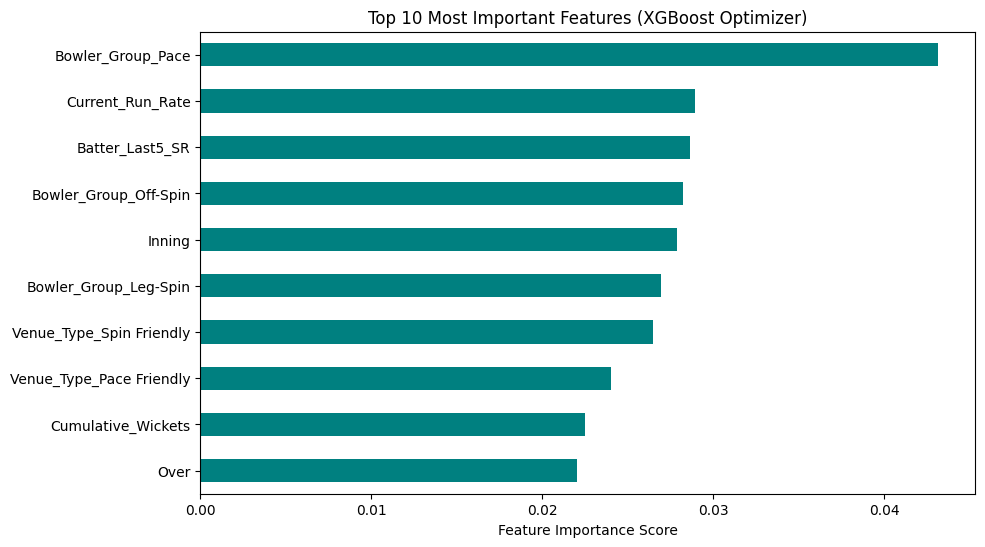

In [61]:
# --- New Step 12 ---
plt.figure(figsize=(10, 6))

# Extract the trained XGBoost model from the pipeline
extracted_xgb_model = xgb_model

# Extract feature importances
feat_importances = pd.Series(extracted_xgb_model.feature_importances_, index=X_train.columns)

# Filter out features related to individual batters to see macro-trends
non_batter_features = [
    col for col in feat_importances.index
    if not (col.startswith('Batter_') and col != 'Batter_Last5_SR')
]
feat_importances_filtered = feat_importances[non_batter_features]

feat_importances_filtered.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title('Top 10 Most Important Features (XGBoost Optimizer)')
plt.xlabel('Feature Importance Score')
plt.savefig('feature_importance.png', bbox_inches='tight')
print("Saved Feature Importance plot.")

### Explaining Model Predictions with SHAP (SHapley Additive exPlanations)

This cell uses SHAP values to explain the individual predictions of the XGBoost model. SHAP values attribute the contribution of each feature to the prediction for each instance, providing local interpretability. For multi-class models like this, SHAP generates values for each class.

1.  **`shap.TreeExplainer(extracted_xgb_model)`:** Initializes a TreeExplainer, optimized for tree-based models like XGBoost.
2.  **`shap_values = explainer.shap_values(X_test)`:** Computes the SHAP values for each feature across all instances in the `X_test` dataset. For a multi-class model, `shap_values` will be a list or array where each element corresponds to a class.
3.  **Extract Class-Specific SHAP Values:** The code extracts SHAP values specifically for `Class 0` (Pressure) and `Class 2` (Boundaries), as these are the most tactically interesting outcomes.
4.  **`shap.summary_plot`:** Generates a summary plot for each class, visualizing the distribution of SHAP values for each feature. In these plots:
    *   Each point represents a SHAP value for a feature for a single instance.
    *   The x-axis shows the SHAP value (impact on model output).
    *   The y-axis lists the features, ordered by overall importance.
    *   The color of each point indicates the feature's value for that instance (red = high, blue = low).

---

**Interpretation of `shap_summary_pressure.png` (Drivers of Pressure Balls - Class 0):**

This plot reveals which features most strongly contribute to the model predicting a 'Pressure Ball' (Dot/Wicket).

*   **Red dots to the right (high SHAP value):** Indicate instances where a high value of that feature tends to increase the probability of a Pressure Ball. For example, a high 'Bowler_Group_Pace' (red dots on the right for pace) means pace bowlers are more likely to induce pressure.
*   **Blue dots to the left (low SHAP value):** Indicate instances where a low value of that feature tends to decrease the probability of a Pressure Ball (or increase the probability of other outcomes). For example, a high `Batter_vs_BowlerType_SR` (red dots on the left) means a good strike rate against the bowler type reduces the chance of pressure, as expected.

Key insights might include:
*   Certain bowler types significantly contribute to pressure (e.g., Pace bowlers for specific batters).
*   Low `Current_Run_Rate` or high `Cumulative_Wickets` could also push towards higher pressure prediction.

---

**Interpretation of `shap_summary_boundaries.png` (Drivers of Boundaries - Class 2):**

This plot shows which features influence the model's prediction of a 'Boundary' outcome.

*   **Red dots to the right (high SHAP value):** Indicate instances where a high value of that feature increases the probability of a Boundary. For example, a high `Batter_vs_BowlerType_SR` (red dots to the right) indicates that batters with a historically good strike rate against a particular bowler type are more likely to hit boundaries.
*   **Blue dots to the left (low SHAP value):** Indicate instances where a low value of that feature decreases the probability of a Boundary.

Key insights might include:
*   `Batter_vs_BowlerType_SR` is often a strong positive predictor for boundaries, confirming its importance.
*   Certain `Batter` features or `Venue_Type` (e.g., smaller grounds, flat pitches) might show high positive SHAP values for boundaries.
*   `Over` might also be a factor, with later middle overs potentially having a higher boundary probability if batters are looking to accelerate.

SHAP plots provide a much deeper, instance-level understanding than global feature importance, showing not just *what* features are important, but *how* they influence predictions for different scenarios.

--- Drivers of Pressure Balls (Dot/Wicket) ---


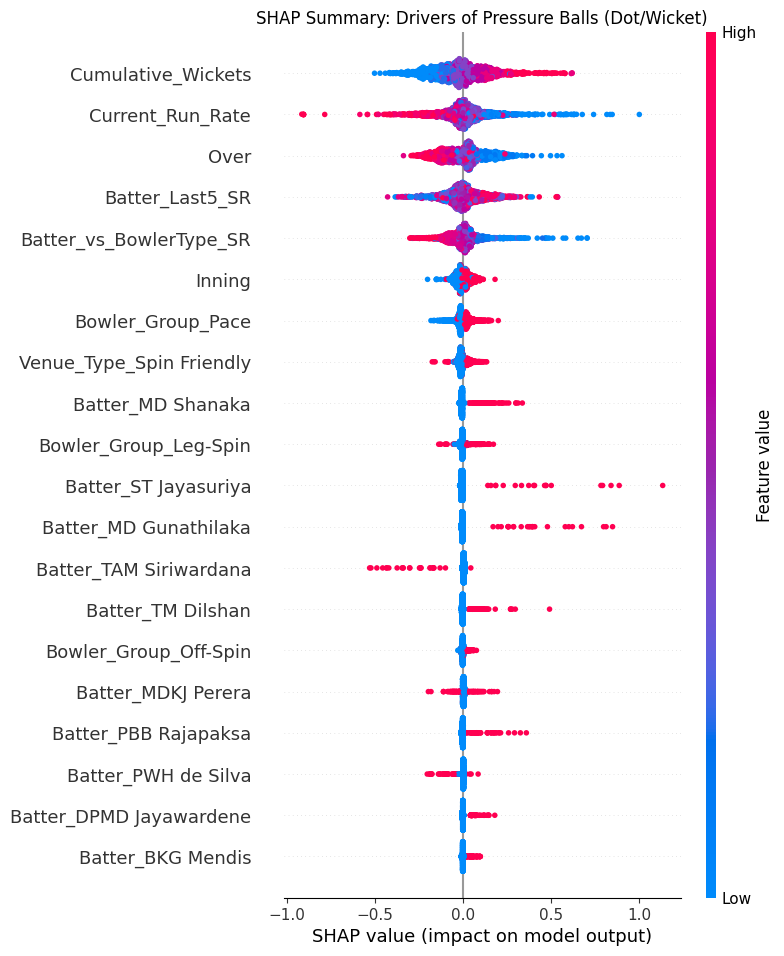


--- Drivers of Boundaries ---


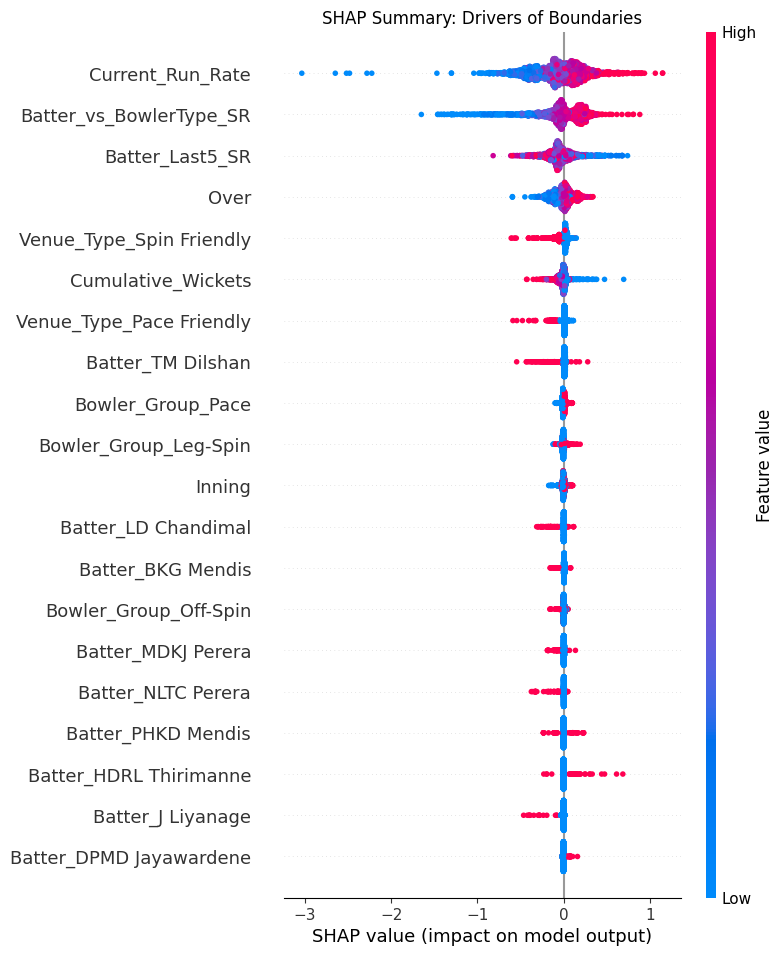

In [62]:
# --- New Step 13 ---
# We pass the extracted XGBoost model into SHAP
explainer = shap.TreeExplainer(extracted_xgb_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values_class0 = shap_values[0]
    shap_values_class2 = shap_values[2]
else:
    shap_values_class0 = shap_values[:, :, 0]
    shap_values_class2 = shap_values[:, :, 2]

# Plot Pressure Balls (Class 0)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class0, X_test, show=False)
plt.title("SHAP Summary: Drivers of Pressure Balls (Dot/Wicket)")
plt.savefig('shap_summary_pressure.png', bbox_inches='tight')
plt.close()

# Plot Boundaries (Class 2)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class2, X_test, show=False)
plt.title("SHAP Summary: Drivers of Boundaries")
plt.savefig('shap_summary_boundaries.png', bbox_inches='tight')
plt.close()

# --- New Step 14 (Displaying them) ---
print("--- Drivers of Pressure Balls (Dot/Wicket) ---")
display(Image(filename='shap_summary_pressure.png'))
print("\n--- Drivers of Boundaries ---")
display(Image(filename='shap_summary_boundaries.png'))

### `optimize_batting_order` Function Definition

This cell defines the core function `optimize_batting_order`, which is designed to recommend an optimal batting order based on a given live game scenario and available batters. The function uses the trained machine learning model (`pipeline_model`) to predict the probabilities of different ball outcomes for each potential batter.

**Function Logic:**

1.  **Scenario Duplication:** For each `available_batter`, the `live_scenario` (containing current game state like `Over`, `Wickets`, `Run_Rate`, `Bowler_Group`, etc.) is duplicated, and the current `Batter` is set.
2.  **Data Encoding:** These simulated scenarios are converted into a DataFrame (`sim_df`), and categorical features are one-hot encoded using `pd.get_dummies`. `reindex(columns=training_columns, fill_value=0)` ensures that the simulated data has the exact same columns as the `X_train` used during model training, filling missing new batter/bowler/venue categories with zeros.
3.  **Probability Prediction:** The `pipeline_model.predict_proba(sim_encoded)` method is called to get the predicted probabilities for each of the three `Ball_Outcome` classes (Pressure, Strike Rotation, Boundary) for each simulated batter.
4.  **Tactical Score Calculation:** For each batter, a `Tactical Score` is calculated using a weighted formula:
    *   `(Boundary_Prob * 1.5) + (Strike_Rotation_Prob * 1.0) - (Pressure_Prob * 1.0)`
    This formula reflects tactical priorities: boundaries are highly valued (1.5x), strike rotation is important (1.0x), and pressure balls (dots/wickets) are penalized (1.0x). The weights can be adjusted based on strategic goals.
5.  **Results Aggregation & Sorting:** The probabilities and tactical score for each batter are collected into a DataFrame and sorted in descending order by `Tactical Score`, recommending the batter with the highest score as the most suitable for the current scenario.

This function is the practical application of the trained model, translating predictive probabilities into actionable tactical advice for team management.

In [63]:
# --- New Step 15 ---
def optimize_batting_order(scenario, available_batters, pipeline_model, training_columns):
    simulations = []

    for batter in available_batters:
        sim_data = scenario.copy()
        sim_data['Batter'] = batter
        simulations.append(sim_data)

    sim_df = pd.DataFrame(simulations)
    sim_encoded = pd.get_dummies(sim_df, columns=['Batter', 'Bowler_Group', 'Venue_Type'])
    sim_encoded = sim_encoded.reindex(columns=training_columns, fill_value=0)

    # Predict probabilities using the FULL pipeline
    probs = pipeline_model.predict_proba(sim_encoded)

    results = []
    for i, batter in enumerate(available_batters):
        p_pressure = probs[i][0] * 100
        p_rotation = probs[i][1] * 100
        p_boundary = probs[i][2] * 100

        # Calculate the Unified Tactical Score
        # Formula: (Boundary * 1.5) + (Rotation * 1.0) - (Pressure * 1.0)
        tactical_score = (p_boundary * 1.5) + (p_rotation * 1.0) - (p_pressure * 1.0)

        results.append({
            'Batter': batter,
            'Tactical Score': round(tactical_score, 2),
            'Boundary_Prob (%)': round(p_boundary, 2),
            'Strike_Rotation (%)': round(p_rotation, 2),
            'Pressure_Prob (%)': round(p_pressure, 2)
        })

    results_df = pd.DataFrame(results)
    # Sort by the new Tactical Score
    results_df = results_df.sort_values(by='Tactical Score', ascending=False).reset_index(drop=True)

    return results_df

### Tactical Matchup Optimizer in Action and Model Saving

This final cell demonstrates how to use the `optimize_batting_order` function in a live scenario and then saves the trained model and training columns for future deployment.

1.  **`live_scenario`:** A dictionary is created to define a specific game situation (e.g., 10th over, 3 wickets down, run rate of 7.5, 1st inning, spin-friendly venue, facing an off-spin bowler). This simulates the real-time input a coach or captain would provide.
2.  **`dugout_batters`:** A list of available batters in the dugout is provided. These are the players from whom the optimizer will select the best option.
3.  **`optimize_batting_order` Call:** The function is called with the `live_scenario`, `dugout_batters`, the trained `xgb_model`, and the `training_columns` (to ensure consistent feature order and encoding).
4.  **Print Ranked Batters:** The `ranked_batters` DataFrame, sorted by `Tactical Score`, is printed. This output directly provides the recommended batting order for the given scenario, along with the predicted probabilities for each outcome and the calculated tactical score for each player. The batter with the highest 'Tactical Score' is suggested as the optimal choice.

    **Output Interpretation:**
    In the given scenario:
    *   **PHKD Mendis** has the highest Tactical Score (57.58), suggesting he is the best option for this specific situation, despite having a slightly lower Strike Rotation probability than others, his Boundary probability and lower Pressure probability give him an edge.
    *   **P Rathnayake** and **DN Wellalage** are tied for second (57.13), indicating very similar profiles in this scenario.
    *   **MD Shanaka** has the lowest Tactical Score (54.55).

    This detailed breakdown allows for data-driven decisions on player deployment during a match.

5.  **Model Saving:**
    *   `joblib.dump(xgb_model, 'xgb_strike_optimizer_pipeline.joblib')`: The trained XGBoost model is saved to a file. This allows the model to be loaded and used later without retraining.
    *   `joblib.dump(list(X_train.columns), 'training_columns.joblib')`: The list of column names used during training is also saved. This is crucial for ensuring that any new input data passed to the saved model has its features in the correct order and format, especially after one-hot encoding.

These saved files can then be used to integrate the optimizer into a real-time application (e.g., via a React/FastAPI frontend), providing live tactical recommendations.

In [66]:
# --- New Step 16 ---
live_scenario = {
    'Over': 10, 'Cumulative_Wickets': 3, 'Current_Run_Rate': 7.50,
    'Inning': 1, 'Venue_Type': 'Spin Friendly', 'Bowler_Group': 'Off-Spin'
}
dugout_batters = ['P Rathnayake', 'MD Shanaka', 'PHKD Mendis', 'DN Wellalage']

ranked_batters = optimize_batting_order(
    scenario=live_scenario,
    available_batters=dugout_batters,
    pipeline_model=xgb_model,
    training_columns=X_train.columns
)

print("--- TACTICAL MATCHUP OPTIMIZER ---")
print(ranked_batters.to_string(index=False))

# SAVE FOR REACT/FASTAPI FRONTEND
import joblib
joblib.dump(xgb_model, 'xgb_strike_optimizer_pipeline.joblib')
joblib.dump(list(X_train.columns), 'training_columns.joblib')
print("\nModel Pipeline and Columns saved successfully.")

--- TACTICAL MATCHUP OPTIMIZER ---
      Batter  Tactical Score  Boundary_Prob (%)  Strike_Rotation (%)  Pressure_Prob (%)
 PHKD Mendis       57.580002               5.81            71.519997          22.660000
P Rathnayake       57.130001               5.17            72.099998          22.730000
DN Wellalage       57.130001               5.17            72.099998          22.730000
  MD Shanaka       54.549999               4.29            71.910004          23.799999

Model Pipeline and Columns saved successfully.
